# Problem Set 3 - Linear Regression, Logistic Regression, and Feature Engineering
## CSCI 5622 - Fall 2022
***
**Name**: $Spencer Shortt$ 
***

This assignment is due on Canvas by **11:59PM on October 28th**.

Submit only this Jupyter notebook to Canvas with the name format `PS3_<yourname>.ipynb`. Do not compress it using tar, rar, zip, etc.
Your solutions to analysis questions should be done in Markdown directly below the associated question. You can add a write-up markdown cell if it wasn't provided.

Remember that you are encouraged to discuss the problems with your classmates and instructors, 
but **you must write all code and solutions on your own**, and list any people or sources consulted.
The only exception to this rule is that you may copy code directly from your own solution to previous homeworks.
***

In [143]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
#import data
#import tests
%matplotlib inline

In [144]:
from google.colab import files

from google.colab import drive
drive.mount('/content/drive')

!cp drive/MyDrive/hw3/data/__init__.py .
!cp drive/MyDrive/hw3/data/kc_house_data.csv .
!cp drive/MyDrive/hw3/tests/test_init.py .
!cp drive/MyDrive/hw3/data/mnist.npz .
!cp drive/MyDrive/hw3/data/movie_review_data.json .


import __init__ as data
import test_init as tests



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Problem 1: Linear Regression (28 points)
For this problem we will be using house price data from King County, Washington (Seattle area) for our linear regression implementations. We will be predicting house prices from the following features:

| Feature | About |
| --- | --- |
| Bedrooms | Number of bedrooms |
| Bathrooms | Number of bathrooms |
| SQFT Living | Interior square footage |
| SQFT Lot | Lot size |
| Floors | Number of floors |
| Waterfront | Whether the property overlooks water (1 if so, 0 otherwise) |
| View | Rating of the quality of the view (0-4) |
| Condition | Rating of the condition of the property (1-5) |
| Grade | Rating of the quality of construction and design (1-13) | 
| SQFT Above | Square footage of interior space above ground level |
| SQFT Basement | Square footage of interior space below ground level |
| Year Built | Year first built |


First, we want to scale the prices to the interval $[0, 1]$ using `MinMaxScaler`. Given an features matrix $X$, the scaling works as follows:
\begin{align}
    X  \leftarrow \frac{X-min(X)}{max(X) - min(X)}
\end{align}

this is performed as a column-wise operation (column = feature).

As usual, $min(X)$ and $max(X)$ are computed on the training set.

- 1.1.a **[2 points]** Complete `MinMaxScaler.fit` to compute and save the column-wise min and max.
- 1.1.b **[1 points]** Complete `MinMaxScaler.transform` to apply the min-max scaling using the computed statistics.

In [145]:
class MinMaxScaler:

    def __init__(self):
        self.min = None
        self.max = None

    def fit(self, X):
        """
        Compute and save the features min and max of shape (num_features,)
        (you can also save them with shape (1, num_features))
        :param X: array of shape (num_samples, num_features)
        :return: fitted scaler
        """
        # Workspace 1.1.a
        #BEGIN 
        # code here

        self.min = np.min(X,axis=0)
        self.max = np.max(X,axis=0)

        #END
        return self

    def transform(self, X):
        """
        Transform the given samples using the precomputed min and max
        :param X: np.array of shape (num_samples, num_features)
        :return: MinMax scaled X, of shape (num_samples, num_features)
        """
        # Workspace 1.1.b
        #BEGIN 
        return (X - self.min)/(self.max - self.min)
        #END

    def fit_transform(self, X):
        """
        Fit using X and then transform it. Useful when we need to scale jsut once.
        """
        self.fit(X)
        return self.transform(X)

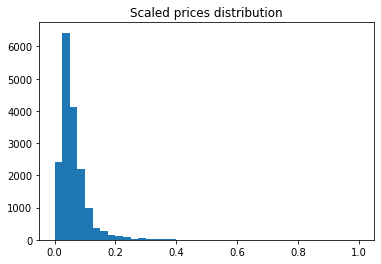

In [146]:
house_prices = data.HousePrices()
minmax_scaler = MinMaxScaler()
# MinMax works on 2-d arrays, so we just need to parse the prices as a single column/feature
# and then squeeze it back to 1-d array
house_prices.y_train = minmax_scaler.fit_transform(house_prices.y_train[:, None])[:, 0]
house_prices.y_test = minmax_scaler.transform(house_prices.y_test[:, None])[:, 0]
plt.hist(house_prices.y_train, bins=40)
plt.title("Scaled prices distribution")
plt.show()

We have seen that Ridge regression adds a regularization term to the least square using the L2 norm.
Ridge regression is part of scikit-learn package ([read more](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)), but we will be building our own implementation.
You can test your implementation against scikit's.

The objective of Ridge regression is to minimize:

\begin{align}
\frac{1}{N}\sum_{i=1}^{N} ||y_i-\mathbf{w}^T \mathbf{x_i}-\mathbf{b}||^2 + \alpha||\mathbf{w}||^2
\end{align}

where $\mathbf{w}$ denotes the coefficients vector for the linear regression model,
$\mathbf{b}$ the intercept vector, $\alpha$ the trade-off regularization parameter, and $N$ the number of samples.

Luckily for us, Ridge regression admits a closed form solution for $\mathbf w$ and $\mathbf{b}$.

Let $X$ be the $N\times d$ matrix whose rows are the training samples $(\mathbf{x_i})_{i\leq N}$ and $Y=(y_i)_{i\leq N}$ the target values.

First, we start by centering the features (columns of X) by subtracting the mean of the column to get centered matrix $\tilde{X}$. Then the solution for the minimization is (trust me):

\begin{align}
&\mathbf{w^*} = (\tilde{X}^T\tilde{X}+ \alpha I)^{-1}\tilde{X}^TY \\
&\mathbf{b^*} = \frac{1}{N} \sum_{i}^{i=N} (y_i - \mathbf{w^*}^T \mathbf{x_i})
\end{align}

Note that:
- The samples in $b^*$ are not centered.
- The predicted targets would be $\hat{y}_i = \mathbf{w^*}^T \mathbf{x_i}+\mathbf{b^*} $
- $\tilde{X}$ is only needed in the `fit` method when we compute $\mathbf{w^*}$ and $\mathbf{b^*}$

A common practice is to scale or normalize (usually normalize) the features before fitting the model. It allows a _fair_ treatment of different features.
You are allowed to use scikit's `StandardScaler` to do the normalization (yes, a thing called scaler is normalizing. Don't @ me, @ sklearn). Do not forget to run the same transformation on the test data before running the prediction.

- 1.2 **[5 points]** Complete the `fit` and `evaluate` methods following the provided descriptions.

In [179]:
from sklearn.metrics import mean_squared_error
class Ridge(object):

    def __init__(self, alpha, normalize=False):
        """
        :param alpha: regularization parameter
        :param normalize: boolean whether to normalize the features or not
        """

        self.alpha = alpha  # our tuning / regularization parameter
        self.coefficients = None  # our weights vector, w (in formulae above)
        self.intercept = None  # our intercept parameter, b (in formulae above)
        self.normalize = normalize  # boolean whether to normalize the features or not
        self.scaler = StandardScaler()  # method by which to normalize the features (depends on self.normalize)

    def fit(self, X, y):
        """
        Fit the ridge model, train it using the provided data
        Calculate the number of non-zero coefficients in the model weights and the norm using np.linalg.norm
        :param X: training features (num_samples, num_features)
        :param y: target values (num_samples)
        :return: tuple (number of non-zeros coefficients of w, norm of w)
        """
        num_nonzero_coefs, coef_norm = 0, 0
        # Workspace 1.2.a
        # TO DO: compute w and b and store them in self.coef_ and self.intercept
        # HINT: use self.scaler first, if and only if self.normalize is True
        #BEGIN 
        # code here

        if self.normalize == True:
          
          X = self.scaler.fit_transform(X)

        X_tilde = X - np.mean(X, axis=0)
        self.coefficients = np.matmul( np.linalg.inv( np.matmul(np.transpose(X_tilde), X_tilde) + self.alpha*np.identity(X_tilde.shape[1])),
                                      np.matmul(np.transpose(X_tilde), y)         )
        #num_nonzero_coefs = len(self.coefficients[self.coefficients != 0])
        num_nonzero_coefs = sum(self.coefficients != 0)
        coef_norm = np.linalg.norm(self.coefficients)


        #self.coefficients = np.reshape(self.coefficients, (len(self.coefficients) , 1))

        
        self.intercept = np.sum( y - np.matmul(X , self.coefficients))/len(y)


        
        

        #END
        return num_nonzero_coefs, coef_norm

    def evaluate(self, X, y):
        """
        Compute Root mean square error (RMSE) between the predicted values and the actual values of the test data
        :param X: instances array of shape (num_samples, num_features)
        :param y: the true targets, of shape (num_samples)
        :return: RMSE
        """

        # Workspace 1.2.b
        # TO DO: predict based on the test features and return the root mean squared error
        #BEGIN 
        y_hat = np.matmul(X , self.coefficients) + self.intercept
        
        root_mean_squared_error = np.sqrt(np.sum((y-y_hat)**2)/len(y))
        #oot_mean_squared_error = mean_squared_error(y, y_hat, squared=False)
        #print("RMSE:" ,root_mean_squared_error)
        #END
        return root_mean_squared_error

In [180]:
# Tests cells, do not remove
# Should run without errors
tests.test_ridge_coef(Ridge, normalize=False)
tests.test_ridge_coef(Ridge, normalize=True)
tests.test_ridge_intercept(Ridge, normalize=True)
tests.test_ridge_intercept(Ridge, normalize=False)


Question 1.2.a: [PASS]
Question 1.2.a: [PASS]
Question 1.2.a: [PASS]
Question 1.2.a: [PASS]


- 1.3 **[3 points]** Produce 3 plots as a function of $\log_{10}(\alpha)$ (logarithmic scale) that compare normalized versus non-normalized Ridge:
    - The number of non-zero coefficients of $\mathbf w$
    - The norm of $\mathbf w$
    - The test RMSE (Root Mean Squared Error)

Use the values of $\alpha$ provided in the cell. What is the best `alpha` for each version of the two models?

To produce multiple plots in the same figure, see the examples [here](https://matplotlib.org/devdocs/gallery/subplots_axes_and_figures/subplots_demo.html)

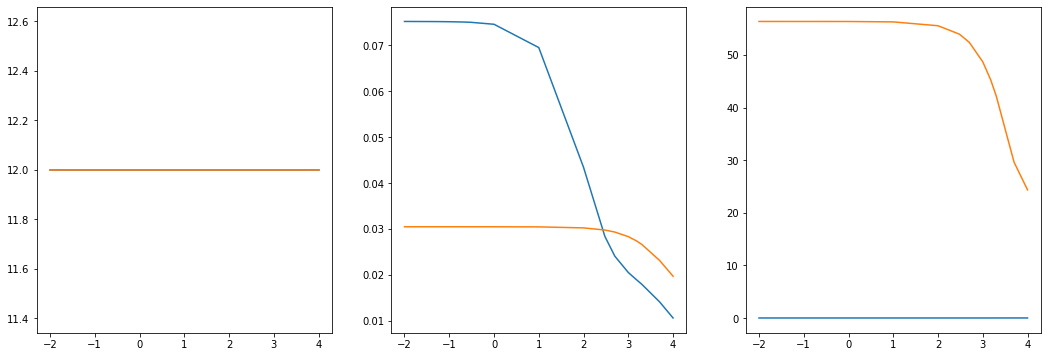

In [178]:
alphas = [0.01, 0.05, 0.1, 0.2, 0.3, 1.0, 10.0, 100.0, 300.0, 500.0, 1e3, 1.5e3, 2e3, 5e3, 1e4]
# Workspace 1.3
#BEGIN 
# code here

nnz_w = []
norm_w = []
rmse =[]

nnz_w_2 = []
norm_w_2 = []
rmse_2 =[]
alphas =np.array(alphas)
for alpha in alphas:
  ridge = Ridge(alpha)
  nnz , norm = ridge.fit(house_prices.X_train , house_prices.y_train)
  nnz_w.append(nnz)
  norm_w.append(norm)
  rmse.append(ridge.evaluate(house_prices.X_train , house_prices.y_train))

  ridge = Ridge(alpha, normalize=True)
  nnz , norm = ridge.fit(house_prices.X_train , house_prices.y_train)
  nnz_w_2.append(nnz)
  norm_w_2.append(norm)
  rmse_2.append(ridge.evaluate(house_prices.X_train , house_prices.y_train))
fig, axs = plt.subplots(1, 3)
fig.set_figheight(6), fig.set_figwidth(18)
axs[0].plot(np.log10(alphas), nnz_w)
axs[1].plot(np.log10(alphas), norm_w)
axs[2].plot(np.log10(alphas), rmse)
axs[0].plot(np.log10(alphas), nnz_w_2)
axs[1].plot(np.log10(alphas), norm_w_2)
axs[2].plot(np.log10(alphas), rmse_2)
plt.show()
#END

#### Workspace 1.3b
%BEGIN

For both the normalized and unnormalized, we get a constant number of number of nonzero coefficients. We get the smallest norm of w when using the largest alpha values for both normalized and unnormalized. We see that we get much better RMSE by using the unnormalized version, but the RMSE decreases for larger alphas.

%END

Based on the results from previous questions, you should have noticed that the interpretation of Ridge regression is not an easy task.
One way to solve that is to use a regularization that adds _sparsity_ to $\mathbf w$ and excludes less important features.
That's what Lasso regression is about.

Lasso uses $l_1$ norm in the regularization term and minimizes:
\begin{align}
\frac{1}{2N}\sum_i ||y_i-\mathbf{w}^T \mathbf{x}_i -\mathbf{b}||^2 + \alpha||\mathbf{w}||_1
\end{align}

It is part of scikit package ([more details](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html))
and you're free to compare your implementation to scikit's.

Unfortunately, there is no closed form solution for Lasso. Instead, we have powerful algorithms to optimize it.
We will be using lasso-path solver from scikit-learn for our implementation to find $\mathbf w^*$
([see more](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.lasso_path.html#sklearn.linear_model.lasso_path)).
(Note that `lasso_path` takes a list of $\alpha$ in the argument `alphas` and not a scalar.)

Similar to Ridge's, $ \mathbf w^*_{lasso} $ is computed by feeding the centered $\tilde{X}$ to `lasso_path`.
Once $\mathbf w^*$ is found, $\mathbf{b}^*$ has the same formula from Ridge regression.

- 1.4 **[4 points]** Complete the Lasso class in the same way Ridge class was created. (You're allowed to use inheritance for a more concise code, as long as the class has `coefficients` and `intercept` attributes.)

In [161]:
from sklearn.linear_model import lasso_path


class Lasso(object):
    def __init__(self, alpha, normalize=False):
        """
        :param alpha: regularization parameter
        :param normalize: boolean whether to normalize the features or not
        """
        self.alpha = alpha  # our tuning / regularization parameter
        self.coefficients = None  # our weights vector, w (in formulae above)
        self.intercept = None  # our intercept parameter, b (in formulae above)
        self.normalize = normalize  # boolean whether to normalize the features or not
        self.scaler = StandardScaler()  # method by which to normalize the features (depends on self.normalize)

    def fit(self, X, y):
        """
        Fit the lasso model, train it using the provided data
        Calculate the number of non-zero coefficients in the model weights and the norm using np.linalg.norm
        :param X: training features (num_samples, num_features)
        :param y: target values (num_samples)
        :return: tuple (number of non-zeros coefficients of w: scalar, norm of w: scalar)
        """

        num_nonzero_coefs, coef_norm = 0, 0
        # Workspace 1.4.a
        # TO DO: compute w and b and store then in self.coef_ and self.intercept
        # TO DO: call lasso_path on the centered features to compute self.coef_
        # HINT: use self.scaler first, if and only if self.normalize is True
        #BEGIN 
        # code here
        if self.normalize == True:  
          X = self.scaler.fit_transform(X)

        X_tilde = X - np.mean(X, axis=0)
        self.alpha = [self.alpha]
        #print(self.alpha)

        _, self.coefficients, _ = lasso_path(X_tilde,y, alphas=self.alpha)
        self.coefficients = self.coefficients.flatten() 

        num_nonzero_coefs = len(self.coefficients[self.coefficients != 0])
        coef_norm = np.linalg.norm(self.coefficients)

        self.intercept = np.sum( y - np.matmul(X , self.coefficients))/len(y)





        #END
        return num_nonzero_coefs, coef_norm

    def evaluate(self, X, y):
        """
        Compute Root mean square error (RMSE) between the predicted values and the actual values  of the test data
        :param X: features array, shape (num_samples, num_features)
        :param y: true targets, shape (num_samples)
        :return: RMSE
        """
        root_mean_squared_error = 0
        # Workspace 1.4.b
        # TO DO: predict based on the test features and return the mean_squared_error
        #BEGIN 
        # code here
        y_hat = np.matmul(X , self.coefficients) + self.intercept
        
        root_mean_squared_error = np.sqrt(np.sum((y-y_hat)**2)/len(y))
        #END
        return root_mean_squared_error

In [135]:
# Tests cell, do not remove
# Test non-normalized Lasso
tests.test_lasso_coef(Lasso, normalize=True)
tests.test_lasso_coef(Lasso, normalize=False)
tests.test_lasso_intercept(Lasso, normalize=True)
tests.test_lasso_intercept(Lasso, normalize=False)

Question 1.4.a: [PASS]
Question 1.4.a: [PASS]
Question 1.4.a: [PASS]
Question 1.4.a: [PASS]


- 1.5 **[3 points]** Produce 3 plots as a function of $\log_{10}(\alpha)$ (logarithmic scale) that compare normalized versus non-normalized Lasso:
    - The number of non-zero coefficients of $\mathbf w$
    - The norm of $\mathbf w$
    - The test RMSE (Root Mean Squared Error)

Use the values of $\alpha$ provided in the cell. What is the best `alpha` for each version of the two models?

Can you get all coefficients of $\mathbf w$ to 0 for the non-normalized Lasso?


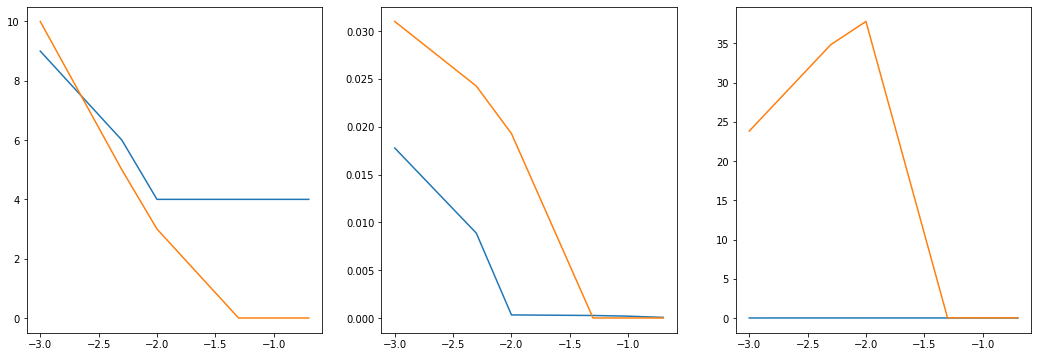

In [181]:
alphas = [1e-3, 5e-3, 0.01, 0.05, 0.1, 0.2]
# Workspace 1.5
#BEGIN 
# code here
nnz_w = []
norm_w = []
rmse =[]

nnz_w_2 = []
norm_w_2 = []
rmse_2 =[]
alphas =np.array(alphas)
for alpha in alphas:
  lasso = Lasso(alpha)
  nnz , norm = lasso.fit(house_prices.X_train , house_prices.y_train)
  nnz_w.append(nnz)
  norm_w.append(norm)
  rmse.append(lasso.evaluate(house_prices.X_train , house_prices.y_train))

  lasso = Lasso(alpha, normalize=True)
  nnz , norm = lasso.fit(house_prices.X_train , house_prices.y_train)
  nnz_w_2.append(nnz)
  norm_w_2.append(norm)
  rmse_2.append(lasso.evaluate(house_prices.X_train , house_prices.y_train))
fig, axs = plt.subplots(1, 3)
fig.set_figheight(6), fig.set_figwidth(18)
axs[0].plot(np.log10(alphas), nnz_w)
axs[1].plot(np.log10(alphas), norm_w)
axs[2].plot(np.log10(alphas), rmse)

axs[0].plot(np.log10(alphas), nnz_w_2)
axs[1].plot(np.log10(alphas), norm_w_2)
axs[2].plot(np.log10(alphas), rmse_2)
plt.show()
#END

#### Workspace 1.5b
%BEGIN

For both the normalized and unnormalized versions we get lower number of nonzero coefficients as alpha increases. Same with the norm, it decreases in both versions as alpha increases. The RMSE is higher for the normalized version for smaller alphas, but goes to zero for both as alpha increases.

%END

- 1.6 **[3 points]** (Write-up) Compare the two algorithms on the house prices dataset: compare the number of non-zero coordinates of Ridge vs Lasso and their RMSE on each dataset. Which type of regression is better? When does normalization improve the RMSE?

#### Workspace 1.6

%BEGIN

It seems like overall Lasso worked better on this dataset, although its a little hard to tell since the normalization makes the rmse so large it is hard to compare the unnormalized versions.

%END

Lasso is expected to have higher level of sparsity compared to Ridge. On the other hand, when the number of features is very large
(larger than the sample size), Lasso can struggle at picking the right features.
Elastic Net try to combine both types of regularization to get the best of both worlds by minimizing:

\begin{align}
\frac{1}{2N} \sum_i ||y_i - \mathbf{w}^T\mathbf{x}_i -\mathbf{b}||^2_2 + \alpha\beta||\mathbf{w}||_1 + \frac{\alpha}{2}(1 - \beta)||\mathbf{w}||^2_2
\end{align}

where $\beta\in[0,1]$ is the $l_1$ ratio ($\beta=1$ for Lasso and $\beta=0$ for Ridge).

We'll be using [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) solver from scikit.

- 1.7 **[2 points]** Complete ElasticNet regression class `Elastic` by implementing fit and evaluate methods with the same signature as Lasso and Ridge. (Again, you can use inheritance)

In [170]:
from sklearn.linear_model import ElasticNet


class Elastic(object):
    def __init__(self, alpha, beta=0.7, normalize=False):
        """
        :param alpha: regularization parameter
        :param beta: l1_ratio for ElasticNet
        :param normalize: normalization flag
        
        """
        self.alpha = alpha
        self.beta = beta
        self.normalize = normalize
        self.scaler = StandardScaler()
        self.coefficients = None
        self.intercept = None
        self._model = ElasticNet(alpha=alpha, l1_ratio=beta)

    def fit(self, X, y):
        """
        fit self._model using the provided data and store the coef and intercept in self.coef_ and self.intercept
        Calculate the number of non-zero coefficients in the model weights and the norm using np.linalg.norm
        :param X: training features (n_samples, n_features)
        :param y: target values (n_samples)
        :return: tuple (number of non-zeros coefficients of w, norm of w)
        """

        num_nonzero_coefs, coef_norm = 0, 0
        # Workspace 1.7.a
        # TO DO: Complete Elastic Net
        # TO DO: save w and b in self.coef_ and self.intercept respectively
        #BEGIN 
        # code here
        if self.normalize == True:  
          X = self.scaler.fit_transform(X)

        X_tilde = X - np.mean(X, axis=0)
        #self.alpha = [self.alpha]
        

        #_, self.coefficients, _ = lasso_path(X,y, alphas=self.alpha)
        regr = ElasticNet(alpha=self.alpha , l1_ratio=self.beta, random_state=0)
        regr.fit(X_tilde, y)
        self.coefficients =  regr.coef_


        num_nonzero_coefs = len(self.coefficients[self.coefficients != 0])
        coef_norm = np.linalg.norm(self.coefficients)

        self.intercept = np.sum( y - np.matmul(X , self.coefficients))/len(y)
        #self.intercepty = 
        #END
        return num_nonzero_coefs, coef_norm

    def evaluate(self, test_x, test_y):
        """
        Compute Root mean square error (RMSE) between the predicted values and the actual values  of the test data
        :param test_x: test features
        :param test_y: test target
        :return: RMSE
        """

        root_mean_squared_error = 0
        # TO DO: predict based on the test features and return the mean_squared_error
        # Workspace 1.7.b
        #BEGIN 
        # code here
        y_hat = np.matmul(test_x , self.coefficients) + self.intercept
        
        root_mean_squared_error = np.sqrt(np.sum((test_y-y_hat)**2)/len(test_y))
        #END
        return root_mean_squared_error

In [168]:
# Tests cell, do not remove
tests.test_elastic_coef(Elastic, normalize=False)
tests.test_elastic_coef(Elastic, normalize=True)
tests.test_elastic_intercept(Elastic, normalize=False)
tests.test_elastic_intercept(Elastic, normalize=False)

Question 1.7.a: [PASS]
Question 1.7.a: [PASS]
Question 1.7.a: [PASS]
Question 1.7.a: [PASS]


- 1.8 **[2 points]** Produce 3 plots as a function of $\log_{10}(\alpha)$ (logarithmic scale) that compare normalized versus non-normalized `Elastic`:
    - The number of non-zero coefficients of $\mathbf w$
    - The norm of $\mathbf w$
    - The test RMSE (Root Mean Squared Error)

Use the values of $\alpha$ provided in the cell, and $\beta= 0.3$. What is the best `alpha` for each version of the two models? How does it compare to the previous models.


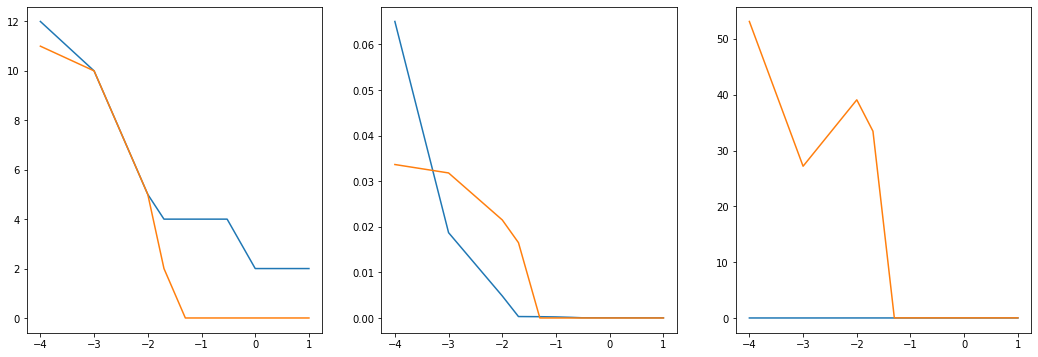

In [174]:
alphas = [1e-4, 1e-3, 1e-2, 0.02, 0.05, 0.1, 0.2, 0.3, 1.0, 2.0, 10.0]
# Workspace 1.2
#BEGIN 
nnz_w = []
norm_w = []
rmse =[]

nnz_w_2 = []
norm_w_2 = []
rmse_2 =[]
alphas =np.array(alphas)
for alpha in alphas:
  elastic = Elastic(alpha)
  nnz , norm = elastic.fit(house_prices.X_train , house_prices.y_train)
  nnz_w.append(nnz)
  norm_w.append(norm)
  rmse.append(elastic.evaluate(house_prices.X_train , house_prices.y_train))

  elastic = Elastic(alpha, normalize=True)
  nnz , norm = elastic.fit(house_prices.X_train , house_prices.y_train)
  nnz_w_2.append(nnz)
  norm_w_2.append(norm)
  rmse_2.append(elastic.evaluate(house_prices.X_train , house_prices.y_train))
fig, axs = plt.subplots(1, 3)
fig.set_figheight(6), fig.set_figwidth(18)
axs[0].plot(np.log10(alphas), nnz_w)
axs[1].plot(np.log10(alphas), norm_w)
axs[2].plot(np.log10(alphas), rmse)
axs[0].plot(np.log10(alphas), nnz_w_2)
axs[1].plot(np.log10(alphas), norm_w_2)
axs[2].plot(np.log10(alphas), rmse_2)
plt.show()
#END

#### Workspace 1.8.b

%BEGIN

Both the normalized and unnormalized versions had the nnz of coefficients decrease with alpha, along with the other two plots. The normalized nnz of coeficients decreased a little faster, but still had much higher rmse.

%END

1.9 **[3 points]** What are the cons and pros of each of the three types of regressions we have tested?

#### Workspace 1.9

%BEGIN

% YOUR ANSWER HERE

%END

***
## Problem 2: Logistic Regression for Binary Classification (30 points)

The second part of this assignment will be dealing with Logistic Regression.
While the name "regression" suggests otherwise, Logistic Regression is actually used for classification.
It's a regression problem because the targets are the continuous likelihoods of the outcomes.

Our dataset is the same one we used in Problem Set 1. We'll start with a binary Logistic Regression. So our class label is `0` if the digit is even and 0 otherwise.

In [139]:
binary_digits = data.BinaryDigits()

Using the same notations from Problem 1 (this time with discrete targets $y_i$ in {0, 1}), _Logistic Regression_ is about minimizing the **N**egative **L**og **L**ikelihood objective defined as:
\begin{align}
\textrm{NLL}(\mathbf{w}) = -\frac{1}{N}\sum_{i=1}^N \left[y_i \log \sigma(\mathbf{w}^T{\mathbf{x_i}}) + (1-y_i)\log(1 - \sigma(\mathbf{w}^T\mathbf{x_i}))\right]
\end{align}

You might be wondering: where is the intercept?
We're including the intercept in $(\mathbf x_i)_i$ since we'll be adding a constant feature $\mathbf x_{i,0} = 1$ to all samples $(\mathbf x_i)_i$.
We will call it the zero-th column and the intercept will be $\mathbf{w}_0$.
This zero-th column will be appended to the training samples in `fit` method and the test samples in `predict` method. $\sigma$ is the sigmoid function seen in class.

The gradient of **NLL** w.r.t $\mathbf{w}$ is:

\begin{align}
\frac{\partial \textrm{NLL}}{\partial \mathbf{w}} = \frac{1}{N} \sum_i \left[\sigma(\mathbf{w}^T\mathbf{x}_i)-y_i)\right]\mathbf{x}_i
\end{align}

- 2.1 **[3 points]** Complete the `sigmoid` function to return the sigmoid values $\sigma(\mathbf{w}^T{\mathbf{x_i}})$ given features array. You have to truncate the score $\mathbf{w}^T{\mathbf{x_i}}$ to the interval $[-25, 25]$ to avoid overflow of `np.exp`


- 2.2 **[3 points]** Finish the `compute_gradient` function to return the derivative of the cost w.r.t. the weights

- 2.3 **[3 points]** Finish the `batch_update` function so that it performs batch gradient descent using the provided batch data

- 2.4 **[4 points]** Finish the `fit` function so that it performs several training epochs and returns the Recall score on the validation data at the end of each epoch. Initialize $\mathbf{w}$ so that $\mathbf{w}_j = \frac{1}{d}$

- 2.5 **[2 points]** Finish the `predict` method to return the predicted labels (either 0 or 1)


In [140]:
from sklearn.metrics import recall_score

class LogisticRegression:

    def __init__(self, eta=0.1, alpha=0):
        """
        Create a logistic regression classifier
        :param eta: Learning rate
        :param alpha: We will use this parameter later (IN BONUS)
        """

        self.w = None  # uninitialized w
        self.eta = eta  # learning rate
        self.initialized = False # flag used to initialize w only once, it allows calling fit multiple times
        self.alpha = alpha  # regularization / penalty term (USED IN BONUS)

    def sigmoid(self, x, threshold=25.0):
        """

        :param x: features array of shape (num_samples, num_features + 1) (zero-th column appended)
        :param threshold: the truncating threshold for np.exp, default to 25.0
        :return: sigmoid values , of shape (num_samples,)
        """
        # Workspace 2.1
        # TO DO: Complete this function to return the output of applying the sigmoid function to the score
        #BEGIN 
        # code here

        #print("w shape: ", self.w.shape)
        #print("x shape: ", x.shape)

        dot_prod = np.matmul( x , self.w)
        dot_prod[dot_prod > 25] = 25
        dot_prod[dot_prod < -25] = -25

        #print("sigma shape", dot_prod.shape)
        return 1/(1+np.exp((-1)*dot_prod))
        #END

    def compute_gradient(self, x, y):
        """
        Return the derivative of the cost w.r.t to the weights. Don't forget to average by batch_size
        :param x:  Feature vector, shape (batch_size, num_features +1), with zero-th column appended
        :param y: real binary class label, shape (batch_size)
        :return: gradient of shape (num_features + 1,)
        """

        # Workspace 2.2
        # TO DO: Finish this function to compute the gradient
        gradient = np.zeros((x.shape[1], ))
        #BEGIN 
        # code here

        gradient = (1/(x.shape[0]))*np.sum((self.sigmoid(x)-y)*np.transpose(x),axis=1 )

        #END
        return gradient

    def batch_update(self, batch_x, batch_y):
        """
        Single self.w update using the batch.
        :param batch_x: array of features (includes the constant feature at column 0), of shape (batch_size, num_features + 1)
        :param batch_y: array of target values, shape (batch_size,)
        :return: nothing
        """

        # Workspace 2.3
        #BEGIN 
        # code here
        self.w = self.w - self.eta*self.compute_gradient(batch_x, batch_y)
        #END

    def fit(self, X, y, epochs=1, batch_size=1, validation_X=None, validation_y=None):
        """
        train the LogisticRegression
        :param X: training features, shape (num_samples, num_features)
        :param y: training labels, shape (num_samples,)
        :param epochs: number of epochs, integer
        :param batch_size: size of batch for gradient update, 1 for SGD
        :param validation_X: validation rows, should default to training data if not provided
        :param validation_y: validation labels
        :return: recall score at the end of each epoch on validation data
        """

        if validation_X is None:
            validation_X, validation_y = X, y
        metrics = []
        # Workspace  2.4
        # TO DO: Process X to append the zero-th constant column and call self.optimize
        # TO DO: Compute average recall on the validation data at the end of each epoch
        # HINT: make sure to initialize w
        #BEGIN 
        # code here
        #y_hat = np.zeros(len(validation_y))
        self.w = np.ones(X.shape[1]+1)/(X.shape[1])
        





        #Z = np.zeros((X.shape[0], X.shape[1]+1))
        #Z[:, 0] = np.ones(X.shape[0])
        #Z[:, 1:] = X
        #X = Z

        X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1) 

        #Z2 = np.zeros((validation_X.shape[0], validation_X.shape[1]+1))
        #Z2[:, 0] = np.ones(validation_X.shape[0])
        #Z2[:, 1:] = validation_X
        #validation_X = Z2


        for i in range(epochs):
          self.optimize(X , y, batch_size)
          y_hat = self.predict(validation_X)
          #y_hat[ self.sigmoid(validation_X) >.5  ] = 1
          #recall = sum((validation_y == 0) & (y_hat==0))/ ( sum((validation_y == 0) & (y_hat==0)) + sum((validation_y == 0) & (y_hat==1))   )
          
          metrics.append(recall_score(validation_y, y_hat))

        #END
        return np.array(metrics)

    def predict(self, X):
        """
        :param X: features array, shape (num_samples, num_features) (without the constant column)
        :return: predicted binary label, shape (num_samples,)
        """
        # Workspace 2.5
        y_hat = np.zeros((X.shape[0],))
        X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)  # We append zero-th column
        #BEGIN 
        # code here
        y_hat[ self.sigmoid(X) >.5  ] = 1
        #END
        return y_hat

    def optimize(self, X, y, batch_size):
        """
        Perform one epoch batch gradient on shuffled data
        :param X: np.array of shape (num_samples, num_features +1), The training data with zero-th column appended
        :param y: target values of shape (num_samples,)
        :param batch_size: batch_size of the batch_update
        :return: None
        """
        
        indices = np.random.permutation(len(X))
        for i in range(0, X.shape[0], batch_size):
            
            batch_x = X[indices[i:i + batch_size]]
            batch_y = y[indices[i:i + batch_size]]
            self.batch_update(batch_x, batch_y)

After completing the class above, loop over the training data and perform batch training with `batch_size=1`(Stochastic Gradient Descent) for 50 epochs, and different values of eta ( see `etas`). Train your model and do the following:

- 2.6 **[5 points]** Plot the recall trend for the different values of eta on the training data (epoch vs recall). (reset random seed for each loop to mitigate the randomness effect)

Use the values provided below

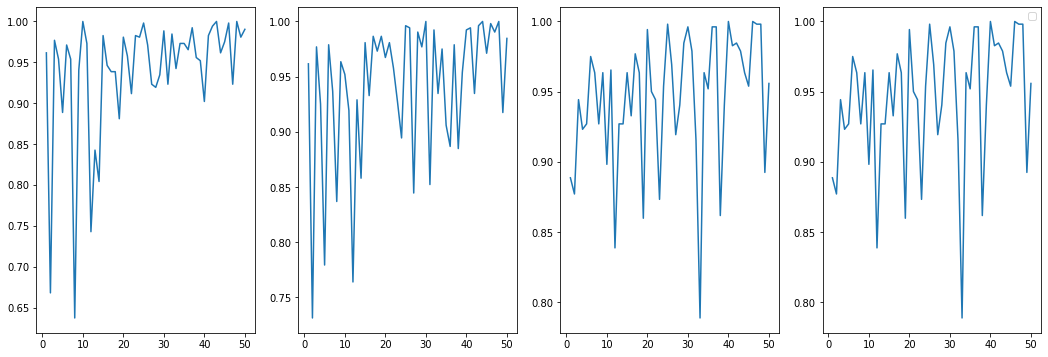

In [141]:
etas = [.001, .01, 0.1, 1]


fig, axs = plt.subplots(1, 4)
fig.set_figheight(6), fig.set_figwidth(18)
i=0
for eta in etas:
    np.random.seed(2022)  # Reset randomness
    # Workspace 2.6
    #BEGIN 
    # code here
    lr = LogisticRegression()
    lr.eta = eta
    axs[i].plot(range(1,51), lr.fit(binary_digits.X_train , binary_digits.y_train,  epochs=50))
    
    i+=1
    #END

plt.legend()
plt.show()
#lr = LogisticRegression()
#lr.fit(binary_digits.X_train , binary_digits.y_train, validation_X=binary_digits.X_valid , validation_y=binary_digits.y_valid)

- 2.7 **[3 points]** Plot the recall trend for the different values of eta on the test data.
(reset random seed for each loop to mitigate the randomness effect)

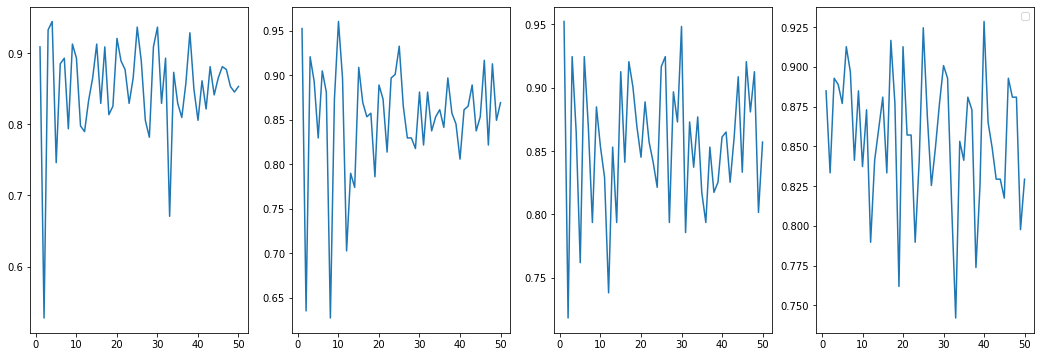

In [77]:
etas = [.0001, .001, .01, 1]
fig, axs = plt.subplots(1, 4)
fig.set_figheight(6), fig.set_figwidth(18)
i=0
for eta in etas:
    np.random.seed(2022)
    # Workspace 2.7
    #BEGIN 
    # code here
    lr = LogisticRegression()
    lr.eta = eta
    axs[i].plot(range(1,51), lr.fit(binary_digits.X_train , binary_digits.y_train, validation_X=binary_digits.X_test , validation_y=binary_digits.y_test, epochs=50))
    
    i+=1
    #END
plt.legend()
plt.show()

This time we want to analyze the effect of varying the batch size. We fix `eta=0.01` and `epochs=50` and we want to
examine the recall on the test set at the end of the training.

- 2.8 **[4 points]** Produce a plot of the recall on the test data at the end of the training as a function of the batch size. Reset the random generator for each iteration.

Use batch sizes provided below

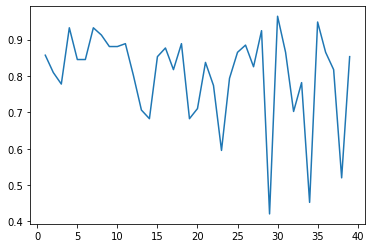

In [142]:
batch_sizes = list(range(1, 40))
recalls = []

for b_size in batch_sizes:
    np.random.seed(2022)
    # Workspace 2.8
    #BEGIN 
    lr = LogisticRegression()
    lr.eta = .01
    recalls.append(lr.fit(binary_digits.X_train , binary_digits.y_train, validation_X=binary_digits.X_test , validation_y=binary_digits.y_test, epochs=50, batch_size=b_size)[-1])
    
    #END
plt.plot(batch_sizes, recalls)
plt.show()

2.9 **[3 points]** How does the learning rate (eta) and the number of epochs affect the performance of the classifier.

#### Workspace 2.9

%BEGIN

The larger the eta, the more variance (higher fluctuation) we see as far as convergence of recall. But we do see some indication of convergence as epochs increase, especially for cases with smaller learning rates.

%END

2.10 (**Bonus**) **[4 points]** Since we're done with the binary regression, we will try to add Ridge regularization:
\begin{align}
\textrm{NLL}(\mathbf{w}) = -\frac{1}{N}\sum_{i=1}^N \left[y_i \log \sigma(\mathbf{w}^T{\mathbf{x}_i}) + (1-y_i)\log(1 - \sigma(\mathbf{w}^T\mathbf{x}_i))\right] + \alpha {||\mathbf{w}||^2}_{\geq1}
\end{align}

This is exactly what we will be using the `alpha` parameter in `LogisticRegression` for.
First, write the gradient formula in the cell below and edit your `compute_gradient` to account for the regularization term. Note that the regularization $||\mathbf{w}||^2$ does not apply to the intercept $\mathbf{w}_0$

#### Workspace 2.10

%BEGIN

% YOUR ANSWER HERE

%END



## Problem 3: Logistic Regression for Multiclass Classification (24)

You will now create a classifier that is commonly referred to as _One Versus All_ Logistic Regression,
where a binary classifier will be trained to identify a single class. The prediction is performed by assigning the label
of the classifier that is most confident in its prediction (the highest score/sigmoid value).

The dataset will be the same one we use in Problem Set 1's KNNClassifier

In [ ]:
from sklearn.preprocessing import StandardScaler
digits = data.Digits()
scaler = StandardScaler()
digits.X_train = scaler.fit_transform(digits.X_train)
digits.X_test = scaler.transform(digits.X_test)

- 3.1 **[3 points]** Complete `one_hot_encoding` to transform your integer labels into a set of binary features via one-hot encoding.
You can assume that it's called after `label_to_index` and `index_to_label` have been defined.


- 3.2 **[2 points]** Complete `normalize_data` to normalize your features. You can use `StandardScaler`
- 3.3 **[4 points]** Complete `predict` method to return the predicted label using the scores from each class classifier.
You might be tempted to call `LogisticRegression.predict`, but you need the sigmoid values to determine the most likely label (and hence have to add the zero-th column in OneVersusAll).

- 3.4 **[2 points]** Complete `evaluate` to return the weighted average recall (WAR) on the validation data (use `recall_score`)
- 3.5 **[6 points]** Complete `fit` function to fit all classifiers with their corresponding labels and compute the WAR at the end of each epoch

Reminder: make no assumption about the number of features/classes in the data.

In [80]:
from sklearn.utils import validation
class OneVersusAll(object):

    def __init__(self, eta=0.1, alpha=0):
        self.eta = eta  # Learning Rate
        self.classifiers = []  # Array of LogisticRegression classifiers
        self.alpha = alpha  # regularization / penalty rate (USED IN BONUS)
        self.scaler = StandardScaler()
        self.fitted = False  # Flag to store whether the model is already fitted to avoid fitting scaler more than once

    def one_hot_encoding(self, y):
        """
        Create one-hot encoding of y
        :param y: shape (num_samples,)
        :return: one hot encoding (num_samples, C) where C is the number of classes in the training labels
        """
        one_hot_encode = np.zeros((y.shape[0], len(self.label_to_index)), dtype=int)
        # Workspace 3.1
        # TO DO: Represent the output vector y as a one hot encoding. Create a matrix M of dimensions (n X C)
        # where n = number of samples, and C for number of classes
        # If y[i] = class j, then M[i] is equal to 1 at position j and 0 elsewhere
        #BEGIN 
        # code here
        
        for i in range(len(np.unique(y))):
          one_hot_encode[y==i, i] = 1
        #END
        return one_hot_encode

    def normalize_data(self, X):
        """
        Fit scaler if it hasn't been done yet and normalize X
        :param X: Raw features, shape (num_samples, num_features)
        :return: Normalized features,  shape (num_samples, num_features)
        """
        # Workspace 3.2
        # TO DO: Normalize the feature values of dataset X, you have to keep track of the mean and variance
        #BEGIN 
        # code here
        
        X = self.scaler.fit_transform(X)
        #END
        return X

    def predict(self, X):
        """
        The usual predict method
        """
        # Workspace 3.3
        # TO DO: Normalize X, process it and return the predicted label using the scores from classifiers
        #BEGIN 
        # code here
        X = self.normalize_data(X)

        X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
        
        sigs = np.zeros(X.shape)
        for j, cl in enumerate(self.classifiers):
          sigs[:,j] = cl.sigmoid(X)
        
        y_hat = np.argmax(sigs , axis=1)
        return y_hat

        #END

    def evaluate(self, test_x, test_y):
        # Workspace 3.4
        #BEGIN 
        # code here
        #print(test_x.shape)
        y_hat = self.predict(test_x)
        #NEED TO MAKE BACK INTO CORRECT LABEL TYPES HERE:
        test_y = np.vectorize(self.label_to_index.get)(test_y)
        #print("ytest ", test_y.shape)
        #print("yhat ", y_hat.shape)
        return recall_score(test_y , y_hat , average='weighted')


        #END

    def fit(self, X, y, batch_size=1, epochs=10, validation_X=None, validation_y=None):
        """
        Similar to LogisticRegression, but for multiclass case
        :return: metrics, containing WAR score at the end of each epoch on the validation data
        """
        self.label_to_index = dict(zip(np.unique(y), range(len(np.unique(y)))))
        self.index_to_label = {v: k for k, v in self.label_to_index.items()}

        metrics = []
        if validation_X is None:
            validation_X, validation_y = X, y
        # Workspace 3.5
        # TO DO: Compute Weighted Average Recall at the end of each epoch
        # TO DO: Process training data and use it to fit self.classifiers and compute the metrics every epoch
        #BEGIN 
        # code here
        
        y = np.vectorize(self.label_to_index.get)(y)
        X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)

        for i in range(len(np.unique(y))):
          #initialize classifiers
          lr = LogisticRegression()
          lr.w = np.ones(X.shape[1])/(X.shape[1])
          self.classifiers.append(lr)
        
        one_hot_encode = self.one_hot_encoding(y)

        for i in range(epochs):
          for j, cl in enumerate(self.classifiers):
            #instead of using y i need to use the column I think from one hot encoding
            cl.optimize(X , one_hot_encode[:,j], batch_size=batch_size)
          y_hat = self.predict(validation_X)
          metrics.append(self.evaluate(validation_X , validation_y))

       
        #END
        return metrics



- 3.6 **[4 points]** Train `OneVersusAll` for 100 epochs using eta=0.1 and batch_size = 64. In the same figure, plot:
    - The WAR metric on the digits training data at the end of each epoch
    - The WAR metric on the digits test data at the end of each epoch
You should also print the best score on each if the partitions.
You might need to adapt LogisticRegression so that fit method can be called multiple times without losing the weights from previous epoch.

For a fair comparison, call `np.random.seed(42)` before each `fit` to reset the random generator.

Max war train:  1.0
Max war test:  0.828


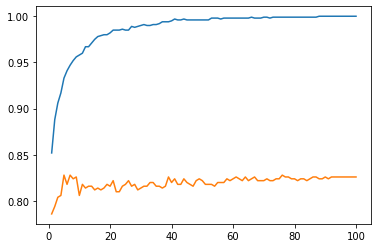

In [83]:
epochs = 100
eta = 0.1
batch_size = 64
# Workspace 3.6
#BEGIN 
# code here
np.random.seed(42)
ova = OneVersusAll()
ova.eta = .1
wars_train = ova.fit(digits.X_train , digits.y_train , batch_size=64, epochs=100 )
plt.plot(range(1,101),wars_train )
np.random.seed(42)
ova = OneVersusAll()
ova.eta = .1
wars_test = ova.fit(digits.X_train , digits.y_train , batch_size=64, epochs=100, validation_X = digits.X_test , validation_y=digits.y_test )
plt.plot(range(1,101), wars_test)


print("Max war train: " , max(wars_train))
print("Max war test: " , max(wars_test))
plt.show()
#END

- 3.7 **[3 points]** Does the WAR improve as we train for more epochs on the two data partitions (train, test)? Why? How does it compare to KNNClassifier? How do you explain the difference?

% Workspace 3.7

%BEGIN

It somewhat improves, although we see what looks like convergence pretty quickly.

%END

- 3.8 **(Bonus)** **[3 points]** Repeat 3.6 and 3.7 using Ridge regularization for the LogisticRegression classifiers with alpha=0.01. How does the regularization affect the performance on train VS test sets?

You have to answer 2.10 before you attempt this question.

In [ ]:
epochs = 100
eta = 0.1
batch_size = 64
alpha = 1e-2
# Workspace 3.8 (code)
#BEGIN 
# code here
#END

#### Workspace 3.8 (write up)

%BEGIN

% YOUR ANSWER HERE

%END

## Problem 4: Feature Engineering (18 points)
So far in all previous problems, we didn't have to worry about creating the features, that is our `X`. We always relied on having it handed to us.
In practical machine learning problems, however, you will have to do some feature engineering yourself in order to get the features matrix `X` before feeding it to the classifier.

For this problem you will work on extracting features from raw data. You will then use scikit-learn [`SGDClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) to complete the classification task.

We will start by importing some libraries and loading our data which contains 2,000 reviews from IMDB along with their sentiment, either positive (`1`) or negative (`0`).


In [102]:
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [103]:
imdb = data.IMDB()
print(f"[Example: {imdb.X_train[1][:157]}], label:{imdb.y_train[1]}")
print(f"[Example: {imdb.X_train[1][:]}], label:{imdb.y_train[1]}")


[Example: underrated movies are a common reoccurrence in show business today . 1998's 'hope floats' was extremely underrated and was one of the best movies of the year], label:1
[Example: underrated movies are a common reoccurrence in show business today . 1998's 'hope floats' was extremely underrated and was one of the best movies of the year . we always get films that make big money at the box-office but critics and audiences pan on them . this year 'double jeopardy' is one of those films . critics are calling it predictable and worthless , audiences are disappointed with it and think it was a disappointment . but as i viewed 'double jeopardy' i found that it was a great movie , it has a surprising sense of humor and a big dose of heart , along with heart-pounding suspense and twists and turns here and there it certainly is a really good movie . the always wonderful ashley judd plays libby parsons , a woman with a seemingly normal life : a great loving husband , a beautiful son and a

Let's call _Featurizer_ any class that is implemented like `StandardScaler` and our initial `MinMaxScaler`. It has:
- a `fit` method that computes any necessary statistics based on our training data (like mean, min or max)
- a `transform` method that generates new features based on given input and the pre-computed statistics
- a `fit_transform` method that combines the two previous methods

We can also combine multiple _Featurizers_ either in a series using [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html):
![Pipeline.png](attachment:Pipeline.png)

Or in parallel using [`FeatureUnion`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html)
![Union.png](attachment:Union.png)

`Pipeline` and `FeatureUnion` are also _Featurizers_.

Both `Pipeline` and `FeatureUnion` take a list of tuples formated as `(features_name: str, featurizer_instance: object)`.

Let's start by extracting some simple features such as the number of sentences in each review.
To do that, we will create a custom scikit-learn feature transformer which will take data as input and returns a feature vector as output.

The feature transformer class has a constructor, a `fit` method. The constructor can be used to store any words or other data that we might need during the feature extraction process.
Feature transformers usually don't need to be fitted, so we will leave that as it is. Most of the work will be done inside the `transform` function.

- 4.1 **[3 points]** Complete the `SentenceCounter` class to extract the number of sentences in each review. 
- 4.2 **[3 points]** Complete the `PunctCounter` class to count the number of "!" and "?" in each review


In [110]:
class SentenceCounter(BaseEstimator, TransformerMixin):
    """
    A custom feature transformer to extract the number of sentences
    """
    def fit(self, data):
        return self

    def transform(self, data):
        """
        :param data: raw data, of length (num_samples,), where each element is a string 
        :return: features array of shape (num_samples, 1)
        """
        features = np.zeros((len(data), 1))
        # Workspace 3.1
        # TODO: Transform reviews into the feature (number of sentences)  
        #BEGIN 
        # code here
        for i in range(len(data)):
          sentence = np.array(data[i].split(" "))
          
          features[i] += sum(sentence =='.')
          features[i] += sum(sentence =='!')
          features[i] += sum(sentence =='?')

        #END
        return features


class PunctCounter(SentenceCounter):
    """
    A custom feature transformer to extract the number of "!" and "?"
    """

    def transform(self, data):
        """
        :param data: raw data, of length (num_samples,), where each element is a string 
        :return: features array of shape (num_samples, 1)
        """
        features = np.zeros((len(data), 1))
        # Workspace 3.2
        # TODO: Transform reviews into the feature (number of "!" and "?")  
        #BEGIN 
        # code here
        for i in range(len(data)):
          
          sentence = np.array(data[i].split(" "))
          features[i] += sum(sentence =='!')
          features[i] += sum(sentence =='?')
        #END
        return features

The `featurizer` instance below combines `FeatureUnion` and `Pipeline` operations. First, we extract the number of punctuations, then normalize the two features.


In [117]:
featurizer = Pipeline([("counts", FeatureUnion([('sentences_count', SentenceCounter()),
                                                ('punct_count', PunctCounter())])),
                       ("normalizer", StandardScaler())])
X_train = featurizer.fit_transform(imdb.X_train)
X_test = featurizer.transform(imdb.X_test)
print(f"means:{np.mean(X_train,axis=0)}, Standard deviations:{np.std(X_train, axis=0)}")
print(X_train.shape, X_test.shape)

means:[9.31001308e-17 2.52179230e-17], Standard deviations:[1. 1.]
(1400, 2) (600, 2)


Let's see how well this simple feature would help us distinguish positive reviews from negative ones. 

In [112]:
# Train the classifier and find the accuracy on the test dataset
lr = SGDClassifier(loss='log', penalty='l2', alpha=0.001, max_iter=2000, shuffle=True, verbose=0, random_state=42)
lr.fit(X_train, imdb.y_train)
y_pred = lr.predict(X_test)
accuracy = accuracy_score(y_pred, imdb.y_test)
print("Accuracy on testing set: ", accuracy)

Accuracy on testing set:  0.5383333333333333


Not that helpful!

Well, that was expected! let's create more transformers to extract more valuable features.  

- 4.3 **[3 points]** Complete the `NegativeCounter` feature transformer to extract the number of negative words (vocabulary is provided) 

- 4.4 **[3 points]** Complete the `PositiveCounter` feature transformer to extract the number of positive words (vocabulary is provided)

HINT: Before you match the vocabulary words to the review text, use [`word_tokenize`](https://www.nltk.org/api/nltk.tokenize.html) from `nltk` to convert reviews into tokens. 

In [113]:
class NegativeCounter(SentenceCounter):
    """
    A custom feature transformer to extract the feature "number of negative words" 
    """

    def __init__(self):
        self.neg_words = ["second-rate", "violent", "moronic", "third-rate", "flawed", "juvenile", "boring",
                          "distasteful", "ordinary", "disgusting", "senseless", "static", "brutal", "confused",
                          "disappointing", "bloody", "silly", "tired", "predictable", "stupid", "uninteresting",
                          "weak", "incredibly tiresome", "trite", "uneven", "cliché ridden", "outdated",
                          "dreadful", "bland", "bad", "worst", "waste"]

    def transform(self, data):
        """
        :param data: raw data
        :return: features array of shape (n_samples, 1)
        """
        features = np.zeros((len(data), 1))

        # Workspace 4.3
        # TODO: Transform reviews into the feature (number of negative words)  
        #BEGIN 
        # code here
        for i in range(len(data)):
          
          sentence = np.array(data[i].split(" "))
          features[i]+= sum(np.in1d(sentence, self.neg_words))
        #END

        return features


class PositiveCounter(NegativeCounter):
    """
    A custom feature transformer to extract the feature "number of positive words"
    """

    def __init__(self):
        self.pos_words = ["first-rate", "insightful", "clever", "charming", "comical", "charismatic", "enjoyable",
                          "uproarious", "original", "tender", "hilarious", "absorbing", "sensitive", "riveting",
                          "intriguing", "powerful", "fascinating", "pleasant", "surprising", "dazzling",
                          "imaginative", "legendary", "unpretentious", "love", "wonderful",
                          "best", "great", "superb", "still", "beautiful"]

    def transform(self, data):
        """
        :param data: raw data
        :return: features array of shape (n_samples, 1)
        """
        features = np.zeros((len(data), 1))

        # Workspace 4.4
        # TODO: Transform reviews into the feature (number of positive words)  
        #BEGIN 
        # code here
        for i in range(len(data)):
          
          sentence = np.array(data[i].split(" "))
          features[i]+= sum(np.in1d(sentence, self.pos_words))
        #END
        return features

Let's see now how well the classifier would perform with these features that we just engineered. 

- 4.5 **[3 points]** Define `second_featurizer` to combine:`num_of_sentences`, `num_of_negative_words`, `num_of_positive_words`, respectively. 

In [118]:
# Workspace 4.5
#BEGIN 
second_featurizer = Pipeline([("counts", FeatureUnion([('sentences_count', SentenceCounter()),
                                                ('pos_count', PositiveCounter()),
                                                ('neg_count', NegativeCounter())])),
                                              ("normalizer", StandardScaler())])
X_train = featurizer.fit_transform(imdb.X_train)
X_test = featurizer.transform(imdb.X_test)
print(f"means:{np.mean(X_train,axis=0)}, Standard deviations:{np.std(X_train, axis=0)}")
print(X_train.shape, X_test.shape)
#END

means:[9.31001308e-17 2.52179230e-17], Standard deviations:[1. 1.]
(1400, 2) (600, 2)


In [119]:
X_train = second_featurizer.fit_transform(imdb.X_train)
X_test = second_featurizer.transform(imdb.X_test)
print(X_train.shape, X_test.shape)
# Train the classifier and find the accuracy on the test dataset
lr = SGDClassifier(loss='log', penalty='l2', alpha=0.001, max_iter=2000, shuffle=True, verbose=0, random_state=42)
lr.fit(X_train, imdb.y_train)
y_pred = lr.predict(X_test)
accuracy = accuracy_score(y_pred, imdb.y_test)
print("Accuracy on testing set: ", accuracy)

(1400, 3) (600, 3)
Accuracy on testing set:  0.685


That's an improvement! Let's try now to include `n-grams` to the list of features.

`N-grams` are all combinations of n-length tokens in a given text. This can be at word level (`word n-grams`) or character level (`char n-grams`) 

For example, if you have the text: `"The movie was great"` , then for this text:

- `unigrams` (`n=1`) at the word level would be `["The", "movie", "was", "great"]` and 
- `bigrams` (`n=2`) at the word level would be `["The movie", "movie was", "was great"]`

and you can generalize this to `n-grams`.

- 4.6 **[3 points]** Define `third_featurizer` to add include an N-gram extractor at the word level.

HINT: use the scikit-learn transformer [`CountVectorizer`](
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)


In [121]:
third_featurizer = FeatureUnion(
    # Workspace 4.6
    # TODO: Add the three feature transformers from 4.5 and a fourth one to extract word n-grams of range 1 to 3
    #BEGIN 
    # code here
    [('sentences_count', SentenceCounter()),
                                                ('pos_count', PositiveCounter()),
                                                ('neg_count', NegativeCounter()) ,
                                 ('count_vectorizer', CountVectorizer(ngram_range=(1,3)))
    #END
])


Let's now see if adding n-grams helped boost the classifier performance. 

In [122]:
X_train = third_featurizer.fit_transform(imdb.X_train)
X_test = third_featurizer.transform(imdb.X_test)
print(X_train.shape, X_test.shape)

(1400, 1116162) (600, 1116162)


In [123]:
# Train the classifier and find the accuracy on the test dataset
lr = SGDClassifier(loss='log', penalty='l2', alpha=0.001, max_iter=2000, shuffle=True, verbose=0, random_state=42)
lr.fit(X_train, imdb.y_train)
y_pred = lr.predict(X_test)
accuracy = accuracy_score(y_pred, imdb.y_test)
print("Accuracy on testing set: ", accuracy)

Accuracy on testing set:  0.8116666666666666


N-grams definitely helped enhance the classifier performance!

- 4.7 **(Bonus)** Try to a achieve better accuracy on IMDB dataset. You're restricted to using SGDClassifier, but you're free to tweak its parameters. You'll get 1 bonus point for each 1% accuracy above 82% that you achieve (rounded-up)!

In [ ]:
# Workspace 4.7
#BEGIN 
# code here
#END